In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.api import VAR
import statsmodels.api as sm

# Load the U.S. macrodata dataset (quarterly data)
data = sm.datasets.macrodata.load_pandas().data

# Display the first few rows
print("Raw Macrodata:")
print(data.head())

Raw Macrodata:
     year  quarter   realgdp  realcons  realinv  realgovt  realdpi    cpi  \
0  1959.0      1.0  2710.349    1707.4  286.898   470.045   1886.9  28.98   
1  1959.0      2.0  2778.801    1733.7  310.859   481.301   1919.7  29.15   
2  1959.0      3.0  2775.488    1751.8  289.226   491.260   1916.4  29.35   
3  1959.0      4.0  2785.204    1753.7  299.356   484.052   1931.3  29.37   
4  1960.0      1.0  2847.699    1770.5  331.722   462.199   1955.5  29.54   

      m1  tbilrate  unemp      pop  infl  realint  
0  139.7      2.82    5.8  177.146  0.00     0.00  
1  141.7      3.08    5.1  177.830  2.34     0.74  
2  140.5      3.82    5.3  178.657  2.74     1.09  
3  140.0      4.33    5.6  179.386  0.27     4.06  
4  139.6      3.50    5.2  180.007  2.31     1.19  


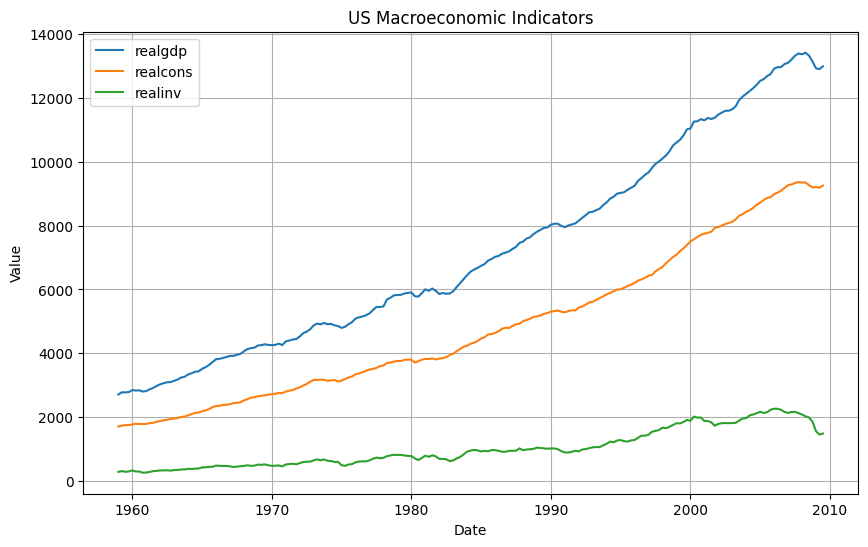

In [3]:
# Define a helper function to convert year and quarter into a date (first day of the quarter)
def convert_to_date(year, quarter):
    year = int(year)
    quarter = int(quarter)
    month = (quarter - 1) * 3 + 1
    return pd.Timestamp(year=year, month=month, day=1)

# Apply the conversion and set the new datetime index
data['date'] = data[['year', 'quarter']].apply(lambda x: convert_to_date(x['year'], x['quarter']), axis=1)
data.set_index('date', inplace=True)

# Select a subset of variables for VAR modeling (e.g., real GDP, real consumption, and real investment)
data = data[['realgdp', 'realcons', 'realinv']]

# Plot the selected variables to inspect the multivariate time series
plt.figure(figsize=(10, 6))
plt.plot(data)
plt.legend(data.columns)
plt.title("US Macroeconomic Indicators")
plt.xlabel("Date")
plt.ylabel("Value")
plt.grid(True)
plt.show()

In [4]:
# Use an 80/20 split for training and testing
n_obs = int(len(data) * 0.8)
train = data.iloc[:n_obs]
test = data.iloc[n_obs:]

print("Training data shape:", train.shape)
print("Testing data shape:", test.shape)

Training data shape: (162, 3)
Testing data shape: (41, 3)


In [5]:
# Initialize the VAR model with the training data
model = VAR(train)

# Select the optimal lag order using AIC (you can set maxlags as needed)
lag_order_results = model.select_order(maxlags=8)
print("Lag Order Selection (AIC):")
print(lag_order_results.summary())

# Use the optimal lag order determined by AIC
optimal_lag = lag_order_results.selected_orders['aic']
print("Optimal lag order according to AIC:", optimal_lag)

# Fit the VAR model using the selected lag order
var_model = model.fit(optimal_lag)
print(var_model.summary())

Lag Order Selection (AIC):
 VAR Order Selection (* highlights the minimums) 
      AIC         BIC         FPE         HQIC   
-------------------------------------------------
0       31.61       31.67   5.349e+13       31.63
1       19.32       19.56   2.455e+08       19.42
2      19.10*      19.51*  1.966e+08*      19.26*
3       19.15       19.74   2.073e+08       19.39
4       19.17       19.94   2.124e+08       19.49
5       19.21       20.16   2.210e+08       19.60
6       19.21       20.34   2.218e+08       19.67
7       19.27       20.57   2.350e+08       19.80
8       19.30       20.78   2.442e+08       19.91
-------------------------------------------------
Optimal lag order according to AIC: 2
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 15, Apr, 2025
Time:                     08:57:32
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)


In [6]:
# Determine the number of lags used in the model
lag_order = var_model.k_ar

# Prepare the forecast input using the last 'lag_order' observations from the training set
forecast_input = train.values[-lag_order:]

# Forecast the future values for the entire test period
steps = len(test)
forecast = var_model.forecast(y=forecast_input, steps=steps)

# Convert the forecast array into a DataFrame with the same columns as the original dataset
forecast_df = pd.DataFrame(forecast, index=test.index, columns=test.columns)

print("Forecasted values:")
print(forecast_df.head())

Forecasted values:
                 realgdp     realcons      realinv
date                                              
1999-07-01  10828.699243  7292.802045  1852.238589
1999-10-01  10968.947922  7389.053080  1889.693539
2000-01-01  11109.538751  7485.844508  1926.883935
2000-04-01  11251.751790  7584.439872  1963.652534
2000-07-01  11396.416968  7684.974591  2000.823824


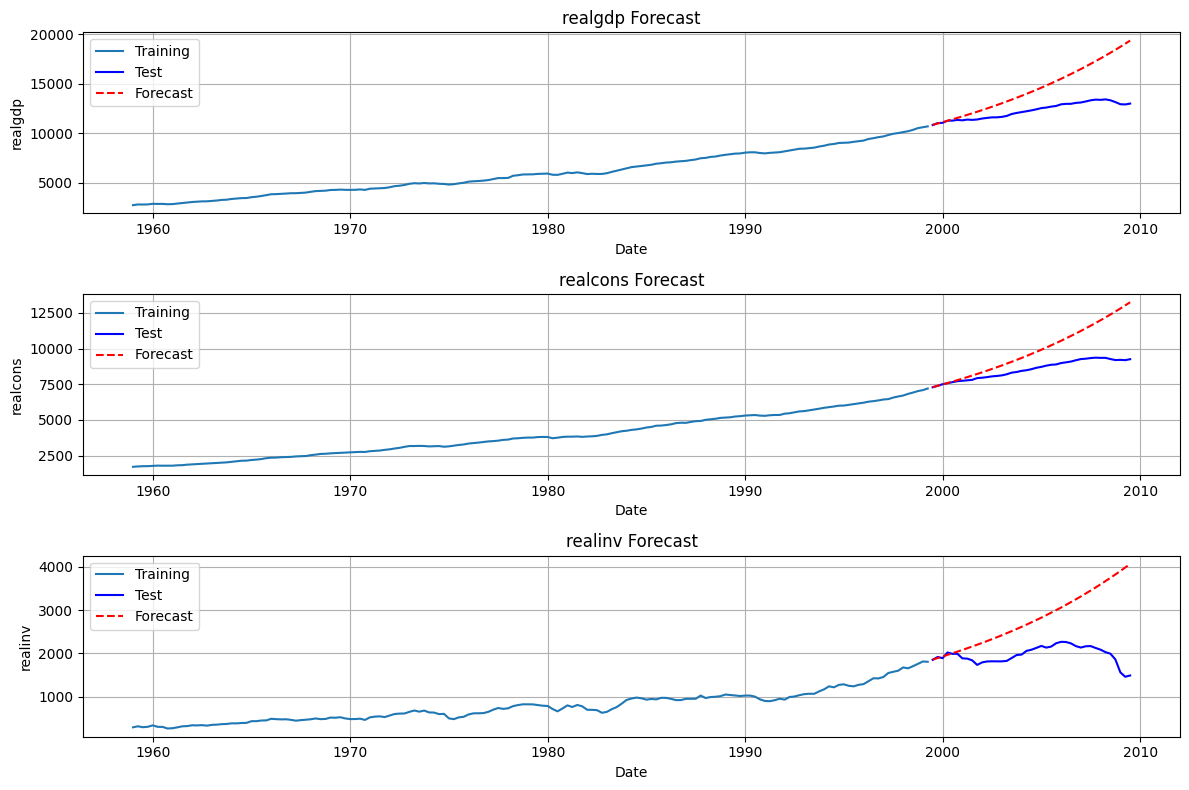

In [7]:
# Plot the forecasted values along with the actual test data for each variable
plt.figure(figsize=(12, 8))
for i, col in enumerate(test.columns, 1):
    plt.subplot(len(test.columns), 1, i)
    plt.plot(train.index, train[col], label="Training")
    plt.plot(test.index, test[col], label="Test", color='blue')
    plt.plot(forecast_df.index, forecast_df[col], label="Forecast", color='red', linestyle='--')
    plt.title(f"{col} Forecast")
    plt.xlabel("Date")
    plt.ylabel(col)
    plt.legend(loc='upper left')
    plt.grid(True)
plt.tight_layout()
plt.show()